# Using CorrHOD

### What does it do ?

In [1]:
import sys 
sys.path.append('../../CorrHOD/')
from CorrHOD.cubic import CorrHOD_cubic
from pathlib import Path

import matplotlib.pyplot as plt
from pycorr import project_to_multipoles

The CorrHOD class needs only the HOD parameters, the cosmology and the path to the config file to be initialized. The HOD parameters have to be provided in a dictionnary, as follows. An `array_to_dict` function can be found in the `utils` module.

A line of sight can also be provided. The tracer for this code is meant to be BGS or LRG, which use the same ???? in AbacusHOD. Other tracers can be used by redefining the tracer parameter within the class.

In [2]:
HOD_params = {
    'logM_cut': 12.0,
    'logM1':    14.525, 
    'sigma':    0.029, 
    'alpha':    1.141, 
    'kappa':    1.089, 
    'alpha_c':  0.0, 
    'alpha_s':  0.0, 
    'Bcent':    0.0, 
    'Bsat':     0.0
}

path2config = Path('../config/config.yaml')

In [3]:
# Initialize the CorrHOD object
Object = CorrHOD_cubic(HOD_params, path2config)
Object.data_params = None 

First, we need to initialize the dark matter simulation. This requires to have already run the `prepare_sim` script from AbacusHOD.

If this has not already be done, an error will be raised. An example of the `prepare_sim` script is given in the ./scripts folder.

In [4]:
Object.initialize_halo()

Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

Then, we populate the halos with galaxies using the HOD parameters. This will give us the galaxy catalog.

In [5]:
mock_dict = Object.populate_halos()

gen mocks 25.13901686668396


If the parameters we choose are correct, the code should return a number density identical to the one we want. Since it is constrained by this value, we want to check that we have a good number density.

A check is already implemented in the `populate_halos` method, that will raise a warning if the number density of the box is not close enough of the constraint, if `data_params` is in the config file (with a gap of the std provided as the error)

In [6]:
# Get the number density in the object to check we get the expected value
boxsize = 2000 # Mpc/h
Ngal = Object.cubic_dict['LRG']['x'].shape[0]
n = Ngal/(boxsize**3)

# Expected number density that should constrains the HOD parameters
if Object.data_params is not None:
    expected_n = Object.data_params['tracer_density_mean']['LRG']
    print(f'Number density: {n:.2e} ({expected_n:.2e} expected)')
else:
    print(f'Number density: {n:.2e}')

Number density: 4.11e-03 (0.00e+00 expected)


To be able to compute correlations functions, we need positions in redshift space. the `get_tracer_positions` method applies the Redshift Space Distorsions (RSD) along the line of sight (los) defined in the initialization of the class ('z' by default)

In [7]:
data_positions = Object.get_tracer_positions()

Then, we can compute the two-point correlation function of the tracer.

The `compute_2pcf`method returns a `pycorr.XXX` object, which contains the correlation function. However, the CorrHOD class stores the separation bin centers and multipoles in a dictionary, which can be accessed as self.CF, with the following keys:

- 's': separation bin centers
- '2PCF': poles of the correlation function

(Other keys will be used later)

In [12]:
xi = Object.compute_2pcf()

[000000.00] [0/1] 05-12 10:25  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000000.00] [0/1] 05-12 10:25  TwoPointCorrelationFunction INFO     Running auto-correlation.
[000000.00] [0/1] 05-12 10:25  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001409.91] [0/1] 05-12 10:48  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.


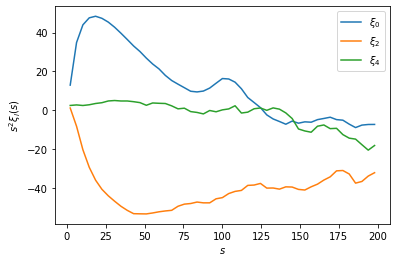

In [13]:
s, poles = project_to_multipoles(xi)

plt.plot(s, poles[0]*s**2, label=r'$\xi_0$')
plt.plot(s, poles[1]*s**2, label=r'$\xi_2$')
plt.plot(s, poles[2]*s**2, label=r'$\xi_4$')
plt.legend()

plt.xlabel(r'$s$')
plt.ylabel(r'$s^2\xi_l(s)$');

In [8]:
import numpy as np
print(f"box max : {np.max(Object.data_positions)}")
print(f"box min : {np.min(Object.data_positions)}")

box max : 1999.999868782192
box min : 0.0


In [9]:
density, quantiles = Object.compute_DensitySplit(cellsize=5, nquantiles=10)

[000014.45] [0/1] 05-15 08:21  FFTWEngine                INFO     Saving wisdom to wisdom.shape-400-400-400.type-float64.nthreads-16.npy.


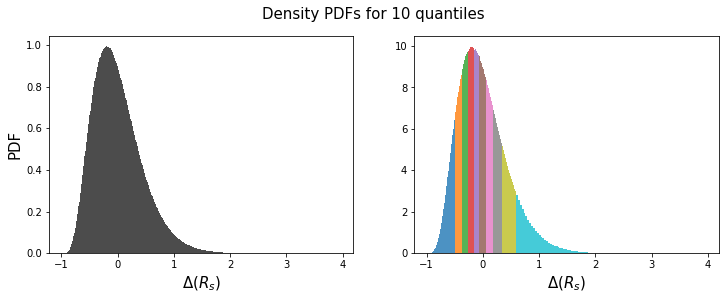

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the quantiles density
nquantiles=10
from pandas import qcut
density_quantiles = []
q_cut = qcut(density, nquantiles, labels=False) 

for i in range(nquantiles):
    density_quantiles.append(density[q_cut == i])
    ax[1].hist(density_quantiles[i], bins=100, density=True, alpha=0.8, label=f'Q{i}')

ax[0].hist(density, bins=500, density=True, alpha=0.7, color='k')

ax[0].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[1].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[0].set_ylabel('PDF', fontsize=15)
fig.suptitle(f'Density PDFs for {nquantiles} quantiles', fontsize=15);

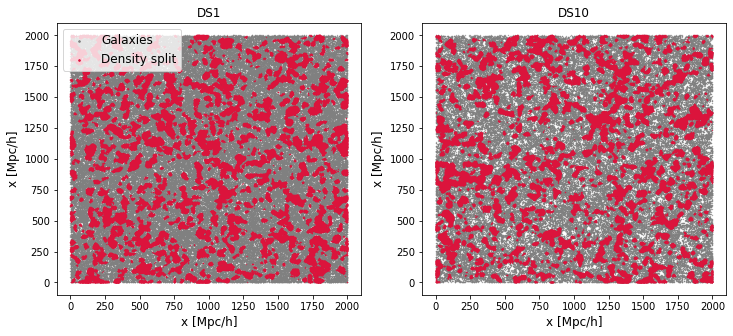

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
boxsize = 2000

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')

for i, ids in enumerate([0, nquantiles-1]):
    cut = quantiles[ids][:, 2] < 50

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1], s=0.1, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids + 1}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
#     ax[i].set_xlim(0, boxsize)
#     ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show()

In [35]:
xi_auto = Object.compute_auto_corr(9)
xi_cross = Object.compute_cross_corr(9)

[000000.00] [0/1] 05-09 12:48  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000000.00] [0/1] 05-09 12:48  TwoPointCorrelationFunction INFO     Running auto-correlation.
[000000.00] [0/1] 05-09 12:48  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000042.08] [0/1] 05-09 12:49  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.
[000000.00] [0/1] 05-09 12:49  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000000.00] [0/1] 05-09 12:49  TwoPointCorrelationFunction INFO     Running cross-correlation.
[000000.00] [0/1] 05-09 12:49  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000140.33] [0/1] 05-09 12:51  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.


Text(0.5, 1.0, 'Auto and Cross Correlation for DS9')

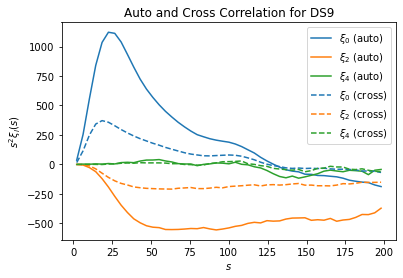

In [41]:
s1, poles1 = project_to_multipoles(xi_auto)
s2, poles2 = project_to_multipoles(xi_cross)

# The separation s can be accessed with : (s1 and s2 are the same since the same edges are used for both auto and cross)
s1 = Object.CF['z']['s']
s2 = Object.CF['z']['s']

# The poles can also be accessed with : 
poles1 = Object.CF['z']['Auto']['DS9']
poles2 = Object.CF['z']['Cross']['DS9']

plt.plot(s1, poles1[0]*s1**2, label=r'$\xi_0$ (auto)', color='C0')
plt.plot(s1, poles1[1]*s1**2, label=r'$\xi_2$ (auto)', color='C1')
plt.plot(s1, poles1[2]*s1**2, label=r'$\xi_4$ (auto)', color='C2')

plt.plot(s2, poles2[0]*s2**2, label=r'$\xi_0$ (cross)', ls='--', color='C0')
plt.plot(s2, poles2[1]*s2**2, label=r'$\xi_2$ (cross)', ls='--', color='C1')
plt.plot(s2, poles2[2]*s2**2, label=r'$\xi_4$ (cross)', ls='--', color='C2')

plt.legend()
plt.xlabel(r'$s$')
plt.ylabel(r'$s^2\xi_l(s)$');
plt.title('Auto and Cross Correlation for DS9')

### The `run_all` method

In [42]:
import sys 
sys.path.append('../../CorrHOD/')
from cubic import CorrHOD_cubic
from pathlib import Path

from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from pycorr import project_to_multipoles

HOD_params = {
    'logM_cut': 12.0,
    'logM1': 14.525, 
    'sigma': 0.029, 
    'alpha': 1.141, 
    'kappa': 1.089, 
    'alpha_c': 0.0, 
    'alpha_s': 0.0, 
    'Bcent': 0.0, 
    'Bsat': 0.0
}

nquantiles=10

path2config = Path('../config/config.yaml')

# Get the number of threads available
import multiprocessing
nthread = multiprocessing.cpu_count()
print(f'Number of threads available: {nthread}')

Object = CorrHOD_cubic(HOD_params, path2config)

Object.run_all(nquantiles=nquantiles, display_times=True, nthread=nthread)

Number of threads available: 256
Running CorrHOD with the following parameters (0) :
Simulation : AbacusSummit_base_c000_ph000
logM_cut : 12.0
logM1 : 14.525
sigma : 0.029
alpha : 1.141
kappa : 1.089
alpha_c : 0.0
alpha_s : 0.0
Bcent : 0.0
Bsat : 0.0
Number density : 1.00e-03 h^3/Mpc^3

Initializing and populating the halos ...
Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading 

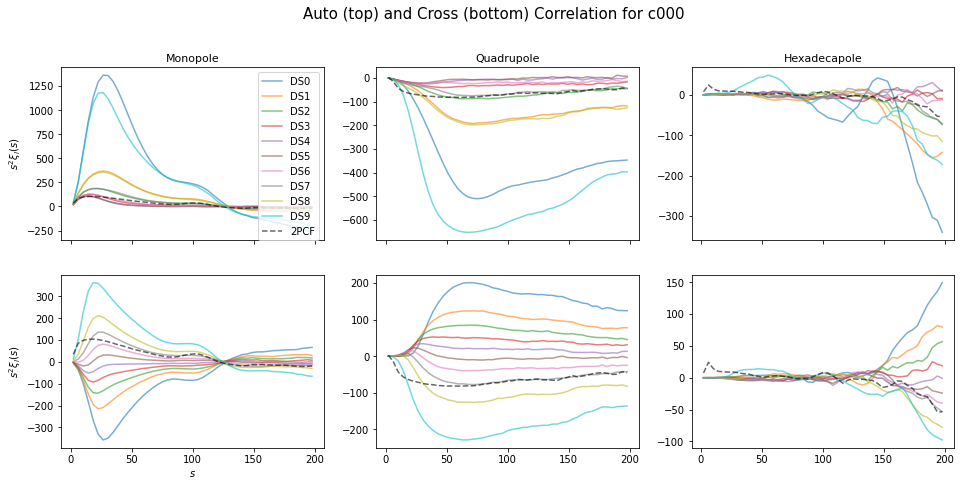

In [ ]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(16, 7))

colors = [f'C{i}' for i in range(nquantiles)]

s = Object.CF['average']['s'] # Get the separation s (identical for all CFs)

for i in range(nquantiles):
    
    color = colors[i]
    alpha = 0.6
    
    # Plot the multipoles of the auto correlation
    poles1 = Object.CF['average']['Auto'][f'DS{i}']
    ax[0,0].plot(s, poles1[0]*s**2, alpha=alpha, color=color, label = f'DS{i}')
    ax[0,1].plot(s, poles1[1]*s**2, alpha=alpha, color=color)
    ax[0,2].plot(s, poles1[2]*s**2, alpha=alpha, color=color)

    # Plot the multipoles of the cross correlation
    poles2 = Object.CF['average']['Cross'][f'DS{i}']
    ax[1,0].plot(s, poles2[0]*s**2, alpha=alpha, color=color)
    ax[1,1].plot(s, poles2[1]*s**2, alpha=alpha, color=color)
    ax[1,2].plot(s, poles2[2]*s**2, alpha=alpha, color=color)
    
#Add the 2PCF on both plots

poles = Object.CF['average']['2PCF']
for i in [0, 1]:
    ax[i,0].plot(s, poles[0]*s**2, alpha=alpha, color='k', ls='--', label='2PCF')
    ax[i,1].plot(s, poles[1]*s**2, alpha=alpha, color='k', ls='--')
    ax[i,2].plot(s, poles[2]*s**2, alpha=alpha, color='k', ls='--')


ax[0,0].legend()
ax[1,0].set_xlabel(r'$s$')
ax[1,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_title('Monopole', fontsize=11)
ax[0,1].set_title('Quadrupole', fontsize=11)
ax[0,2].set_title('Hexadecapole', fontsize=11)
fig.suptitle('Auto (top) and Cross (bottom) Correlation for c000', fontsize=15, y=1);

In [ ]:
# Access the times

# The times are stored in a dictionary
times_dict = Object.times_dict

# It contains the following keys:
pprint(times_dict)

# Let's compute some interesting times to look at

total_time = times_dict['run_all']

mean_los_time = np.mean([times_dict[los]['run_los'] for los in ['x', 'y', 'z']], axis=0)

mean_2PCF_time = np.mean([times_dict[los]['compute_2pcf'] for los in ['x', 'y', 'z']], axis=0)

mean_auto_time = np.mean([times_dict[los]['compute_auto_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)

mean_cross_time = np.mean([times_dict[los]['compute_cross_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)

total_auto_time = np.mean([np.sum([times_dict[los]['compute_auto_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)

total_cross_time = np.mean([np.sum([times_dict[los]['compute_cross_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)

#Display the times
print(f'Total time: {total_time:.2f} s')

print(f'Mean time for computing a LOS: {mean_los_time:.2f} s')

print(f'Mean time for computing the 2PCF: {mean_2PCF_time:.2f} s')

print(f'Mean time for computing an auto correlation: {mean_auto_time:.2f} s')

print(f'Mean time for computing a cross correlation: {mean_cross_time:.2f} s')

print(f'Mean time for computing all auto correlations: {total_auto_time:.2f} s')

print(f'Mean time for computing all cross correlations: {total_cross_time:.2f} s')



{'initialize_halo': 167.21607947349548,
 'run_all': 10403.23976302147,
 'x': {'compute_2pcf': 303.56483340263367,
       'compute_DensitySplit': 12.647656679153442,
       'compute_auto_corr': {'DS0': 73.86614799499512,
                             'DS1': 64.15292763710022,
                             'DS2': 72.6037986278534,
                             'DS3': 79.27877807617188,
                             'DS4': 71.24095726013184,
                             'DS5': 68.96741604804993,
                             'DS6': 81.69982266426086,
                             'DS7': 78.6139919757843,
                             'DS8': 72.82690739631653,
                             'DS9': 79.20847463607788},
       'compute_cross_corr': {'DS0': 243.92246460914612,
                              'DS1': 232.67027187347412,
                              'DS2': 239.31630778312683,
                              'DS3': 241.8193039894104,
                              'DS4': 237.67234563827515,
  

In [ ]:
# Save the elements for later
path = '/global/homes/s/sbouchar/Abacus_HOD/CorrHOD/data'
Object.save(path=path, save_all=True)